### 두 가지 클러스터링 알고리즘인 BIRCH(Balanced Iterative Reducing and Clustering using Hierarchies)와 MiniBatchKMeans를 사용하여 대규모 데이터셋을 클러스터링하고 결과를 시각화

BIRCH without global clustering as the final step took 0.72 seconds
n_clusters : 158
BIRCH with global clustering as the final step took 1.64 seconds
n_clusters : 100
Time taken to run MiniBatchKMeans 0.55 seconds


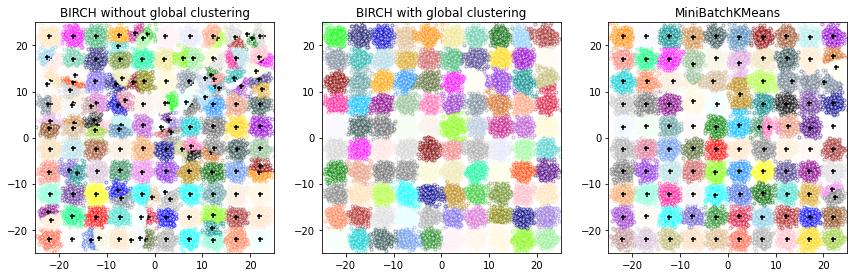

In [1]:
from itertools import cycle
from time import time

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from joblib import cpu_count

from sklearn.cluster import Birch, MiniBatchKMeans
from sklearn.datasets import make_blobs

xx = np.linspace(-22, 22, 10)
yy = np.linspace(-22, 22, 10)
xx, yy = np.meshgrid(xx, yy)
n_centers = np.hstack((np.ravel(xx)[:, np.newaxis], np.ravel(yy)[:, np.newaxis]))

X, y = make_blobs(n_samples=25000, centers=n_centers, random_state=0)

colors_ = cycle(colors.cnames.keys())

fig = plt.figure(figsize=(12, 4))
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.1, top=0.9)

# BIRCH 클러스터링:
# 하나는 전역 클러스터링 단계 없이(subclusters만 사용), 다른 하나는 전역 클러스터링 단계를 포함하여(최종 클러스터 수가 100개) 클러스터링을 수행
birch_models = [
    Birch(threshold=1.7, n_clusters=None),
    Birch(threshold=1.7, n_clusters=100),
]
final_step = ["without global clustering", "with global clustering"]

for ind, (birch_model, info) in enumerate(zip(birch_models, final_step)):
    t = time()
    birch_model.fit(X)
    print("BIRCH %s as the final step took %0.2f seconds" % (info, (time() - t)))

    # Plot result
    labels = birch_model.labels_
    centroids = birch_model.subcluster_centers_
    n_clusters = np.unique(labels).size
    print("n_clusters : %d" % n_clusters)

    ax = fig.add_subplot(1, 3, ind + 1)
    for this_centroid, k, col in zip(centroids, range(n_clusters), colors_):
        mask = labels == k
        ax.scatter(X[mask, 0], X[mask, 1], c="w", edgecolor=col, marker=".", alpha=0.5)
        if birch_model.n_clusters is None:
            ax.scatter(this_centroid[0], this_centroid[1], marker="+", c="k", s=25)
    ax.set_ylim([-25, 25])
    ax.set_xlim([-25, 25])
    ax.set_autoscaley_on(False)
    ax.set_title("BIRCH %s" % info)

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=100,
    batch_size=256 * cpu_count(),
    n_init=10,
    max_no_improvement=10,
    verbose=0,
    random_state=0,
)
t0 = time()
mbk.fit(X)
t_mini_batch = time() - t0
mbk_means_labels_unique = np.unique(mbk.labels_)

ax = fig.add_subplot(1, 3, 3)
for this_centroid, k, col in zip(mbk.cluster_centers_, range(n_clusters), colors_):
    mask = mbk.labels_ == k
    ax.scatter(X[mask, 0], X[mask, 1], marker=".", c="w", edgecolor=col, alpha=0.5)
    ax.scatter(this_centroid[0], this_centroid[1], marker="+", c="k", s=25)
ax.set_xlim([-25, 25])
ax.set_ylim([-25, 25])
ax.set_title("MiniBatchKMeans")
ax.set_autoscaley_on(False)
plt.show()